## Question 1

In [1]:
from abc import ABC, abstractmethod
import scipy.stats as stats
import numpy as np

class Distribution(ABC):
    @abstractmethod
    def sample(self, size=None):
        pass

    @abstractmethod
    def pdf(self, x):
        pass

class Normal(Distribution):
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, size=None):
        return stats.norm.rvs(self.mu, self.sigma, size=size)

    def pdf(self, x):
        return stats.norm.pdf(x, self.mu, self.sigma)

def run_abc_rejection(N, observed_data, prior_dist, generate_data, compute_discrepancy, tolerance=0.1):
    sample = []
    num_tries = 0

    while len(sample) < N:
        num_tries += 1
        theta = prior_dist.sample()
        generated_data = generate_data(theta, len(observed_data))
        if compute_discrepancy(observed_data, generated_data) < tolerance:
            sample.append(theta)
    
    return sample, N / num_tries

In [2]:
# Constants
example_a = 1
example_p = 1/2
example_M = 100
example_sigma_1 = np.sqrt(0.1)
example_sigma = np.sqrt(3)
example_mean = 0
example_N = 500

class ExampleLikelihoodDist(Distribution):
    def __init__(self, theta, a, sigma, p):
        self.theta = theta
        self.a = a
        self.sigma = sigma
        self.p = p
    
    def sample(self, size=None):
        prob = stats.uniform.rvs(0, 1)

        if prob < self.p:
            return stats.norm.rvs(self.theta, self.sigma, size=size)

        return stats.norm.rvs(self.theta+self.a, self.sigma, size=size)

    def pdf(self, x):
        return NotImplementedError

class ExamplePosteriorDist(Distribution):
    def __init__(self, M, mean, a, sigma, sigma_1):
        self.a = a
        self.sigma = sigma
        self.sigma_1 = sigma_1
        self.mean = mean
        self.M = M
        self.alpha = 1 / (1 + np.exp(a * (mean - a/2) * (self.M / (self.M*sigma**2 + sigma_1**2))))
        self.normal_1 = Normal((sigma**2 / (sigma**2 + sigma_1**2/self.M) )* mean, sigma_1**2/(self.M + sigma_1**2/sigma**2))
        self.normal_2 = Normal((sigma**2 / (sigma**2 + sigma_1**2/self.M)) * (mean-a), sigma_1**2/(self.M + sigma_1**2/sigma**2))
    
    def sample(self, size=None):
        return NotImplementedError
    
    def pdf(self, x):
        return self.alpha * self.normal_1.pdf(x) + (1-self.alpha) * self.normal_2.pdf(x)

def generate_data(theta, size):
    return ExampleLikelihoodDist(theta, example_a, example_sigma_1, example_p).sample(size=size)

def compute_example_discrepancy(observed_data, generated_data):
    return np.abs(np.mean(generated_data) - example_mean)

prior_dist = Normal(0, example_sigma)
example_theta = prior_dist.sample()
observed_data = generate_data(example_theta, example_M)
posterior_dist = ExamplePosteriorDist(example_M, example_mean, example_a, example_sigma, example_sigma_1)

tolerances = [0.75, 0.25, 0.1, 0.025]
q1_tolerance_samples = []

for tolerance in tolerances:
    sample, acceptance_rate = run_abc_rejection(example_N, observed_data, prior_dist, generate_data, compute_example_discrepancy, tolerance)
    print(f"tolerance: {tolerance}, acceptance rate: {acceptance_rate*100:.2f}%")
    q1_tolerance_samples.append(sample)

tolerance: 0.75, acceptance rate: 30.60%
tolerance: 0.25, acceptance rate: 10.54%
tolerance: 0.1, acceptance rate: 4.08%
tolerance: 0.025, acceptance rate: 1.14%


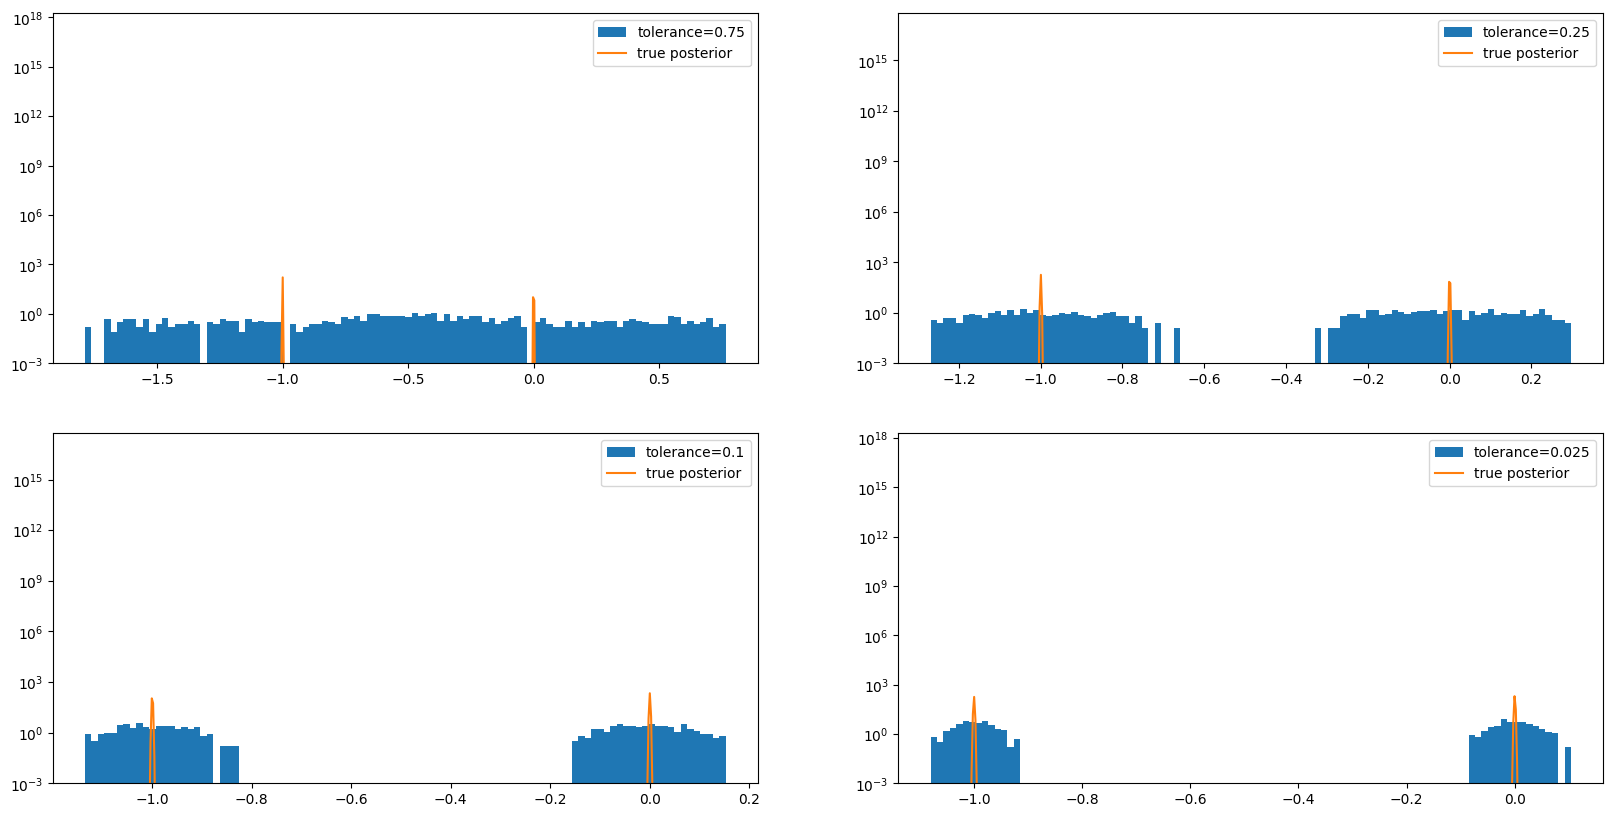

In [5]:
import matplotlib.pyplot as plt

def plot_sample(samples, posterior_dist, tolerances):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for i, sample in enumerate(samples):
        axis = axes[i//2, i%2]
        axis.hist(sample, bins=100, label=f"tolerance={tolerances[i]}", density=True)
        x = np.linspace(min(sample), max(sample), example_N)
        posterior_density = [posterior_dist.pdf(theta) for theta in x]
        axis.plot(x, posterior_density, label="true posterior")
        axis.set_yscale("log")
        axis.set_ylim(bottom=0.001)
        axis.legend()
    plt.show()

plot_sample(q1_tolerance_samples, posterior_dist, tolerances)

## Question 2

## Question 3

In [19]:
from functools import partial

def run_abc_mcmc(N, observed_data, proposal_dist_class, prior_dist, generate_data, compute_discrepancy, tolerance=0.1, theta_0=0):
    sample = [theta_0]
    num_tries = 0

    while len(sample) < N:
        num_tries += 1
        proposal_dist = proposal_dist_class(sample[-1])
        theta = proposal_dist.sample()
        generated_data = generate_data(theta, len(observed_data))
        if compute_discrepancy(observed_data, generated_data) < tolerance:
            alpha = min(1, (prior_dist.pdf(theta) * proposal_dist.pdf(sample[-1])) / (prior_dist.pdf(sample[-1]) * proposal_dist.pdf(theta)))
            prob = stats.uniform.rvs(0, 1)
            if prob < alpha:
                sample.append(theta)
    
    return sample, N / num_tries

class ExampleProposalDist(Distribution):
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
    
    def sample(self, size=None):
        return stats.norm.rvs(self.theta, self.sigma, size=size)

    def pdf(self, x):
        return stats.norm.pdf(x, self.theta, self.sigma)

q3_tolerance_samples = []
proposal_dist_class = partial(ExampleProposalDist, sigma=np.sqrt(0.1))
burn_in = 200

for tolerance in tolerances:
    sample, acceptance_rate = run_abc_mcmc(example_N+burn_in, observed_data, proposal_dist_class, prior_dist, generate_data, compute_example_discrepancy, tolerance)
    print(f"tolerance: {tolerance}, acceptance rate: {acceptance_rate*100:.2f}%")
    q3_tolerance_samples.append(sample[burn_in:])

tolerance: 0.75, acceptance rate: 56.45%
tolerance: 0.25, acceptance rate: 26.90%
tolerance: 0.1, acceptance rate: 12.72%
tolerance: 0.025, acceptance rate: 3.04%


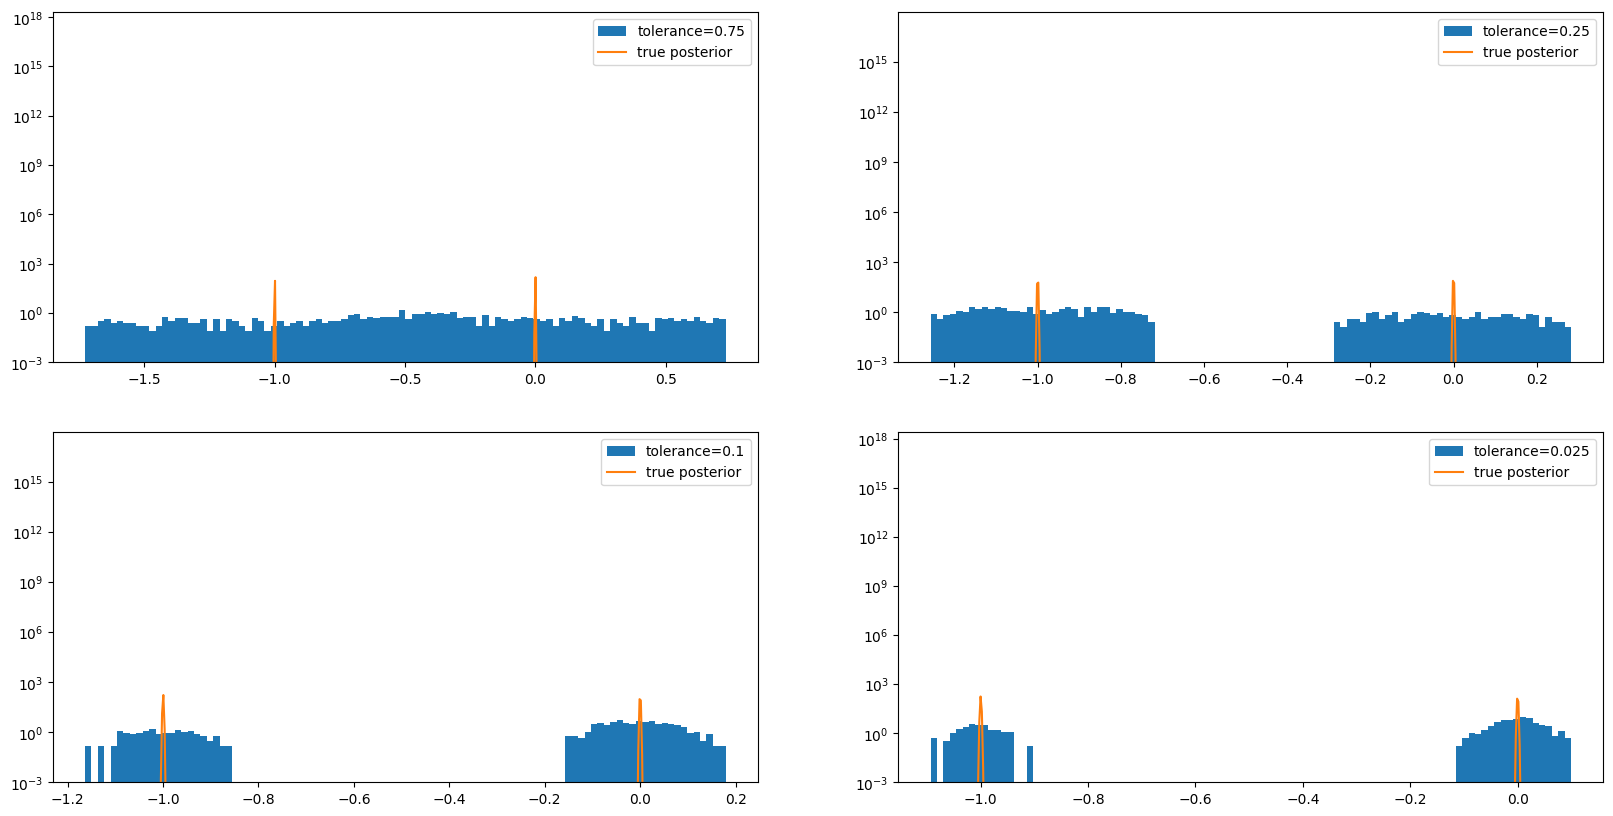

In [20]:
plot_sample(q3_tolerance_samples, posterior_dist, tolerances)

## Question 4

## Question 5

## Question 6